This notebook best viewed here: https://nbviewer.jupyter.org

This notebook is for the interior variety of Douglas fir GEA mapping pops

#### Purpose
• I've run the baypass commands across four servers, I need to gather the jobs and concatenate results.

#### Notebook outline

- __rsync files from servers__
    - I execute the rsync commands to transfer files from the executing servers to our lab server
- __check what needs to be done__
    - given the number of gfiles and chains, make sure all of the commands have been executed/transferred
- __gather all of the wanted resfiles and concat into single dataframes__
    - gather the files with BF, label SNP IDs, and concat into single dataframe
- __Remove newREPEATS and add newSNPs__
    - after baypass was kicked off, we received an updated softmasked reference and some of the previous SNPs turned into REPEATS and some of the previous REPEATS turned into SNPs. From the baypass output, remove newREPEATS and add newSNPs
- __Rank loci__
    - Rank each locus for each chain by converting dB to BF (BF = 10^(dB / 10); dB = 10*log10(BF))
    - Caclulate mean BF across 5 chains, rank each locus based on mean
    - Create boolean column with True if locus is ranked in top 1% for at least 3/5 chains
    - Create boolean column with True if locus has BF >= 15 for at least 3/5 chains
    - Create boolean column with True if locus has BF >= 20 for at least 3/5 chains
- __look at BF scores for consistent top 1% ranks__
    - explore the top 1% of ranks
    - count number of SNPs >= BF thresholds {15, 20}, print if not all SNPs >= thresh are consistently in top 1% across chains

In [1]:
from pythonimports import *

In [2]:
# dir names
baydir = '/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass'
cmddir = op.join(baydir, 'cmd_files')
rundir = op.join(cmddir, 'run_01')
gfile_dir = op.join(baydir, 'individual_gfiles')
shdir = op.join(cmddir, 'shfiles')
resdir = op.join(cmddir, 'results')

# rsync files from servers

In [3]:
!echo $HOSTNAME

itbioyeaman03.ucalgary.ca


In [10]:
lview,dview = get_client()

56 56


In [11]:
rsyncdir = makedir(op.join(baydir, 'rsync_files'))
rsyncdir

'/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/rsync_files'

In [12]:
fs(rsyncdir)

['/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/rsync_files/arc_rsync_cmds.txt',
 '/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/rsync_files/beluga_rsync_cmds.txt',
 '/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/rsync_files/cedar_rsync_cmds.txt',
 '/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/rsync_files/graham_new_rsync_cmds.txt',
 '/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/rsync_files/graham_rsync_cmds.txt']

In [13]:
def exe(cmd):
    """execute system command."""
    import os
    os.system(cmd)

In [14]:
def submit_cmds(cmds):
    """Execute a list of system commands. Return cmd if there was an error."""
    jobs = []
    for cmd in nb(cmds):
        jobs.append(lview.apply_async(exe, cmd))
    watch_async(jobs)
    
    badcmds = []
    for i,j in enumerate(jobs):
        try:
            x=j.r
        except:
            badcmds.append(cmds[i])
    print('len(badcmds) = ', len(badcmds))
    
    return badcmds

In [15]:
def check_realfiles(cmds, new=False):
    """Make sure all transferred files exist.
    new is used if transferring the results from SNPs that were once REPEATS
    """
    realfiles = []
#     if new is True:
#         rundir = newrundir
#         gfile_dir = newgfiledir
#         shdir = newshdir
#         resdir = newresdir
    for d in [rundir, gfile_dir, shdir, resdir]:
        realfiles.extend(fs(d, dirs=False))
    
    expfiles = []
    for cmd in cmds:
        expfiles.append(cmd.split()[-1])
    
    print('len(realfiles) = ', len(realfiles))
    print('len(expfiles) =', len(expfiles))
    
    needed = list(set(expfiles) - set(realfiles))
    
    print('needed = ', len(needed))
    
    needed_cmds = []
    for n in needed:
        for cmd in cmds:
            if n in cmd:
                needed_cmds.append(cmd)
    print('needed_cmds = ', len(needed_cmds))
    return needed_cmds

#### cedar cmds

In [56]:
# first from cedar
cmds = read('/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/rsync_files/cedar_rsync_cmds.txt')
len(cmds)

15130

In [11]:
dnames = []
for cmd in cmds:
    dst = cmd.split()[-1]
    dnames.append(op.dirname(dst))
for d in uni(dnames):
    assert op.exists(d)

In [12]:
cmds = [cmd for cmd in cmds if '.out' in cmd or '.sh' in cmd]
len(cmds)

15130

In [14]:
badcmds = submit_cmds(needed)

  0%|          | 0/30 [00:00<?, ?it/s]


Watching 30 jobs ...


100%|██████████| 30/30 [00:18<00:00,  1.65it/s]

len(badcmds) =  0


In [57]:
needed = check_realfiles(cmds)
len(needed)

len(realfiles) =  49162
len(expfiles) = 15130
needed =  0
needed_cmds =  0


0

#### arc cmds

In [50]:
arccmds = read('/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/rsync_files/arc_rsync_cmds.txt')
len(arccmds)

4599

In [18]:
arccmds = [cmd for cmd in arccmds if '.out' in cmd or '.sh' in cmd]
len(arccmds)

4599

In [26]:
badcmds = submit_cmds(arccmds)

  0%|          | 4/4599 [00:00<02:18, 33.12it/s]


Watching 4599 jobs ...


100%|██████████| 4599/4599 [2:09:26<00:00,  1.69s/it]   

len(badcmds) =  0


In [51]:
needed = check_realfiles(arccmds)
len(needed)

len(realfiles) =  49162
len(expfiles) = 4599
needed =  0
needed_cmds =  0


0

In [29]:
badcmds = submit_cmds(needed)

  0%|          | 0/48 [00:00<?, ?it/s]


Watching 48 jobs ...


100%|██████████| 48/48 [01:08<00:00,  1.44s/it]

len(badcmds) =  0


#### beluga cmds

In [52]:
belugacmds = read('/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/rsync_files/beluga_rsync_cmds.txt')
len(belugacmds)

13880

In [43]:
belugacmds = [cmd for cmd in belugacmds if '.sh' in cmd or '.out' in cmd]
len(belugacmds)

13880

In [44]:
badbelugacmds = submit_cmds(belugacmds)

  0%|          | 0/13880 [00:00<?, ?it/s]


Watching 13880 jobs ...


100%|██████████| 13880/13880 [12:53<00:00, 17.94it/s] 


len(badcmds) =  0


In [53]:
beluganeeded = check_realfiles(belugacmds)
len(beluganeeded)

len(realfiles) =  49162
len(expfiles) = 13880
needed =  0
needed_cmds =  0


0

In [46]:
x = submit_cmds(beluganeeded)

0it [00:00, ?it/s]
0it [00:00, ?it/s]


Watching 0 jobs ...
len(badcmds) =  0


#### graham cmds

In [54]:
gcmds = read('/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/rsync_files/graham_rsync_cmds.txt')
len(gcmds)

17206

In [40]:
gcmds = [cmd for cmd in gcmds if '.sh' in cmd or '.out' in cmd]
len(gcmds)

17206

In [41]:
badgcmds = submit_cmds(gcmds)

  0%|          | 0/17206 [00:00<?, ?it/s]


Watching 17206 jobs ...


100%|██████████| 17206/17206 [15:05<00:00, 19.00it/s] 


len(badcmds) =  0


In [55]:
needed = check_realfiles(gcmds)

len(realfiles) =  49162
len(expfiles) = 17206
needed =  0
needed_cmds =  0


In [48]:
badgcmds = submit_cmds(needed)

0it [00:00, ?it/s]
0it [00:00, ?it/s]


Watching 0 jobs ...
len(badcmds) =  0


#### cmds from graham on newsnps

In [16]:
newrundir = '/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/cmd_files/run_02'
newshdir = '/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/cmd_files/new_shfiles'
newgfiledir = '/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/cmd_files/new_individual_gfiles'
newresdir = '/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/cmd_files/new_results'

In [17]:
cmds = read('/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/rsync_files/graham_new_rsync_cmds.txt')
len(cmds)

206

In [22]:
badgcmds = submit_cmds(needed)

100%|██████████| 4/4 [00:00<00:00, 1394.38it/s]



Watching 4 jobs ...


100%|██████████| 4/4 [00:00<00:00, 14.86it/s]

len(badcmds) =  0


In [23]:
needed = check_realfiles(cmds, new=True)

len(realfiles) =  223
len(expfiles) = 206
needed =  0
needed_cmds =  0


# check what needs to be done
given the number of gfiles and chains, make sure all of the commands have been executed/transferred

#### first check to make sure every sh file was exececuted (ie, check that each has a slurm .out file)

In [4]:
# the the shfiles and out files
shfiles = fs(shdir, endswith='.sh')
outs = fs(shdir, endswith='.out')
len(shfiles), len(outs)

(188, 239)

In [5]:
# figure out why there are more outs than shfiles (I prob accidentally ran a job >1x)
pairs = {}
for sh in shfiles:
    pairs[sh] = []
    for out in outs:
        if op.basename(sh).replace('.sh', '') in out:
            pairs[sh].append(out)
for sh,outfiles in pairs.items():
    if len(outfiles) < 1:
        print(sh, len(outfiles))

#### go through catfiles and make sure all of the commands inside were run

In [6]:
resdir

'/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/cmd_files/results'

In [7]:
# get one of the files for each of the commands that executed successfully (count the succesful cmds)
resfiles = fs(resdir, endswith='DIC.out')
len(resfiles)

8990

In [8]:
# get the files with the baypass commands - this matches number of sh files (good)
catfiles = fs(rundir, pattern='catfile')
len(catfiles)

188

In [9]:
# iterate through catfile commands and make sure there's a result for each
found = {}  # map prefix to output file
exe = {}  # map prefix to command used
found_gfiles = []
needed_cmds = []
for cat in nb(catfiles):
    # get the commands
    cmds = read(cat)
    
    # assign prefixes (= num cmds) to their output
    for cmd in cmds:
        prefix = cmd.split("-outprefix")[1].split()[0]
        gfile = prefix.split("_chain")[0]
        found_gfiles.append(gfile)
        assert prefix not in found
        exe[prefix] = cmd
        found[prefix] = []
        for res in resfiles:
            if prefix in op.basename(res):
                found[prefix].append(res)
prefix

100%|██████████| 188/188 [00:59<00:00,  3.14it/s]


'interior_all_snps_ADP-lt-1000_gfile_1797_chain_5'

In [10]:
len(found_gfiles),luni(found_gfiles)

(8990, 1798)

In [11]:
# figure out which prefixes have zero output (and need to be reran) or cmds with >1 output (impossible...)
needed_cmds = []
for prefix,reslist in found.items():
    if len(reslist) == 0:
        needed_cmds.append(exe[prefix])  # get the cmd that needs to be executed
    elif len(reslist) > 1:
        print('\n', prefix, len(reslist))  # this shouldn't be possible, check anyway, print if so
len(needed_cmds)  # came back and counted after submitting 32 jobs below

0

In [12]:
needed_cmds

[]

In [18]:
len(fs(gfile_dir, endswith='.txt'))  # matches found_gfiles

1798

# gather all of the wanted resfiles and concat into single dataframes

gather the files with BF, label SNP IDs, label environmental covariables, and concat into single dataframe

#### first get SNPs that were in the origal SNPs 

These gfiles were created before we got the updated softmasked reference. Not all of these are still SNPs, some are now REPEATs

In [3]:
lview,dview = get_client()

56 56


In [4]:
bffiles = fs(resdir, endswith='betai_reg.out')
xtxfiles = fs(resdir, endswith='pi_xtx.out')
len(bffiles), len(xtxfiles)

(8990, 8990)

In [5]:
bf = pd.read_table(bffiles[0], delim_whitespace=True)
bf.head()

,COVARIABLE,MRK,M_Pearson,SD_Pearson,BF(dB),Beta_is,SD_Beta_is,eBPis
0,1,1,0.019328,0.158403,-12.063518,0.001142,0.006460,0.065669
1,1,2,0.036242,0.160090,-9.262433,0.002351,0.008852,0.102060
2,1,3,-0.055807,0.142212,-10.787758,-0.003216,0.008893,0.144069
3,1,4,-0.088973,0.138312,-9.022399,-0.005157,0.013441,0.154140
4,1,5,-0.092610,0.141636,-9.507932,-0.004699,0.010623,0.181615


In [6]:
xtx = pd.read_table(xtxfiles[0], delim_whitespace=True)
xtx.head()

,MRK,M_P,SD_P,M_XtX,SD_XtX,XtXst,log10(1/pval)
0,1,0.979105,0.018118,34.497275,8.232360,8.442409,2.300000e-07
1,2,0.961510,0.044092,35.085043,8.287244,11.252697,1.099000e-05
2,3,0.945952,0.056978,35.720709,8.320441,22.439873,1.670308e-02
3,4,0.873878,0.057879,37.744704,8.348635,36.114346,3.341330e-01
4,5,0.926504,0.044429,35.731524,8.328053,28.518397,9.247043e-02


In [7]:
op.basename(bffiles[0])

'interior_all_snps_ADP-lt-1000_gfile_0000_chain_1_summary_betai_reg.out'

In [37]:
newbffiles[0]

'/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/cmd_files/new_results/interior_all_newsnps_ADP-lt-1000_gfile_00_chain_1_summary_betai_reg.out'

In [27]:
def label_snps(resfile):
    """Label baypass resfiles with SNP ID using pkl files saved in 002_kickoff."""
    import os
    import pandas
    # find the gfile associated with resfile
    prefix = os.path.basename(resfile).split("_chain")[0]
    chain = "chain_%s" % os.path.basename(resfile).split(prefix)[1].split("_")[2]
    
    # get the pkl file that has the ordered list of SNP IDs for the gfile
    if 'new' in resfile:
        newgfile_dir = os.path.dirname(resfile).replace("new_results", "new_individual_gfiles")
        pklfile = os.path.join(newgfile_dir, f'{prefix}_noheaderidx.pkl')
    else:
        pklfile = os.path.join(gfile_dir, f'{prefix}_noheaderidx.pkl')
    gloci = pklload(pklfile)  # read in rows with SNPIDs, but only one column
    
    # read in the resfile
    df = pandas.read_table(resfile, delim_whitespace=True)
    
    # map MRK column (SNP index) to locus name
    gdict = dict((num+1, locus) for num,locus in enumerate(gloci))
    
    # map covariable column to environment ID
    edict = dict((num+1, env) for num,env in enumerate(efile.index))
    
    # split each covariable (env) in to its own file, label index with SNP ID
    df['env'] = df['COVARIABLE'].map(edict)
    envdfs = {chain:{}}
    for env in uni(df['env']):
        envdfs[chain][env] = df[df['env']==env].copy()
        envdfs[chain][env].index = envdfs[chain][env]['MRK'].map(gdict)
        envdfs[chain][env].index.names = ['']

    return envdfs

efile = pd.read_table(op.join(baydir, 'interior_efile_std_HEADERIDX.txt'), index_col=0, usecols=[0,1])
dview['efile'] = efile
dview['uni'] = uni
dview['gfile_dir'] = gfile_dir
dview['pklload'] = pklload

In [11]:
# label SNP IDs in parallel
jobs = []
for bffile in nb(bffiles):
    jobs.append(lview.apply_async(label_snps, bffile))
watch_async(jobs)

100%|██████████| 8990/8990 [00:08<00:00, 1086.84it/s]



Watching 8990 jobs ...


100%|██████████| 8990/8990 [14:27<00:00, 10.36it/s]


In [12]:
# gather output by environment
envlist = {}
for j in nb(jobs):
    assert len(keys(j.r)) == 1
    chain = keys(j.r)[0]
    if chain not in envlist:
        envlist[chain] = {}
    for env in j.r[chain]:
        if env not in envlist[chain]:
            envlist[chain][env] = []
        envlist[chain][env].append(j.r[chain][env])
keys(envlist)

100%|██████████| 8990/8990 [00:00<00:00, 17506.00it/s]


['chain_1', 'chain_2', 'chain_3', 'chain_4', 'chain_5']

In [13]:
j.r[chain][env].head()

,COVARIABLE,MRK,M_Pearson,SD_Pearson,BF(dB),Beta_is,SD_Beta_is,eBPis,env
,,,,,,,,,
jcf7190016526461-5448,12,1,-0.095118,0.152770,-4.463277,-0.008106,0.009520,0.403917,bFFP
jcf7190016526461-5454,12,2,0.038502,0.160866,-14.859149,0.001015,0.004519,0.085000,bFFP
jcf7190016526461-5455,12,3,-0.022288,0.145244,-12.883302,-0.000809,0.005610,0.052921,bFFP
jcf7190016526461-5461,12,4,-0.041600,0.153691,-12.291447,-0.001399,0.004889,0.110801,bFFP
jcf7190016526461-5471,12,5,-0.062306,0.158242,-12.226679,-0.001982,0.005106,0.156171,bFFP


In [14]:
chain,env

('chain_5', 'bFFP')

In [15]:
# concatenate environmental output by each chain, print out num snps for each env for each chain
chaindfs = {}
for chain,envs in envlist.items():
    assert len(envs) == 19
    if chain not in chaindfs:
        chaindfs[chain] = {}
    for env,dfs in nb(envs.items(), desc=chain):
        if env not in chaindfs[chain]:
            chaindfs[chain][env] = pd.concat(dfs)
        else:
            print('crap ', chain, env)
for chain in chaindfs:
    print(ColorText(chain).bold())
    for env in chaindfs[chain]:
        print('\t',env, nrow(chaindfs[chain][env]))

chain_5: 100%|██████████| 19/19 [00:12<00:00,  1.48it/s]

chain_1
	 DD_0 2696227
	 FFP 2696227
	 SHM 2696227
	 TD 2696227
	 AHM 2696227
	 MWMT 2696227
	 MCMT 2696227
	 MSP 2696227
	 Eref 2696227
	 NFFD 2696227
	 DD5 2696227
	 eFFP 2696227
	 CMD 2696227
	 MAP 2696227
	 PAS 2696227
	 bFFP 2696227
	 MAT 2696227
	 EMT 2696227
	 EXT 2696227
chain_2
	 MAP 2696227
	 TD 2696227
	 DD5 2696227
	 CMD 2696227
	 EMT 2696227
	 DD_0 2696227
	 SHM 2696227
	 MSP 2696227
	 PAS 2696227
	 MCMT 2696227
	 FFP 2696227
	 bFFP 2696227
	 Eref 2696227
	 eFFP 2696227
	 MWMT 2696227
	 EXT 2696227
	 AHM 2696227
	 NFFD 2696227
	 MAT 2696227
chain_3
	 AHM 2696227
	 MWMT 2696227
	 DD_0 2696227
	 MSP 2696227
	 EMT 2696227
	 Eref 2696227
	 MAP 2696227
	 FFP 2696227
	 SHM 2696227
	 EXT 2696227
	 PAS 2696227
	 MAT 2696227
	 NFFD 2696227
	 bFFP 2696227
	 TD 2696227
	 eFFP 2696227
	 DD5 2696227
	 MCMT 2696227
	 CMD 2696227
chain_4
	 MAP 2696227
	 CMD 2696227
	 EMT 2696227
	 MCMT 2696227
	 Eref 2696227
	 MAT 2696227
	 DD5 2696227
	 DD_0 2696227
	 NFFD 2696227
	 EXT 2696227
	 bFFP 2

In [16]:
# concatenate environmental output by each env, combine chains into single df
dflst = {}
for chain,envs in envlist.items():
    for env,dfs in nb(envs.items(), desc=chain):
        if env not in dflst:
            dflst[env] = []
        df = pd.concat(dfs)
        df.columns = [f"{chain}-{col}" for col in df.columns]
        dflst[env].append(df)
# combine chains for each env - should have done this in parallel
envdfs = {}
for env,lst in nb(dflst.items(), desc='combo'):
    assert len(lst) == 5
    df = pd.merge(lst[0], lst[1], left_index=True, right_index=True)
    df2 = pd.merge(lst[2], lst[3], left_index=True, right_index=True)
    df3 = pd.merge(df, df2, left_index=True, right_index=True)
    envdfs[env] = pd.merge(df3, lst[4], left_index=True, right_index=True)
    
    
envdfs[env].head()           

combo: 100%|██████████| 19/19 [04:22<00:00, 13.82s/it]


,chain_1-COVARIABLE,chain_1-MRK,chain_1-M_Pearson,chain_1-SD_Pearson,chain_1-BF(dB),chain_1-Beta_is,chain_1-SD_Beta_is,chain_1-eBPis,chain_1-env,chain_2-COVARIABLE,chain_2-MRK,chain_2-M_Pearson,chain_2-SD_Pearson,chain_2-BF(dB),chain_2-Beta_is,chain_2-SD_Beta_is,chain_2-eBPis,chain_2-env,chain_3-COVARIABLE,chain_3-MRK,chain_3-M_Pearson,chain_3-SD_Pearson,chain_3-BF(dB),chain_3-Beta_is,chain_3-SD_Beta_is,chain_3-eBPis,chain_3-env,chain_4-COVARIABLE,chain_4-MRK,chain_4-M_Pearson,chain_4-SD_Pearson,chain_4-BF(dB),chain_4-Beta_is,chain_4-SD_Beta_is,chain_4-eBPis,chain_4-env,chain_5-COVARIABLE,chain_5-MRK,chain_5-M_Pearson,chain_5-SD_Pearson,chain_5-BF(dB),chain_5-Beta_is,chain_5-SD_Beta_is,chain_5-eBPis,chain_5-env
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
jcf7190000000000-77657,17,1,0.019362,0.159456,-12.069102,0.001243,0.006569,0.070646,EXT,17,1,0.014799,0.162190,-9.800956,0.000909,0.006735,0.049343,EXT,17,1,0.021291,0.157260,-11.354296,0.001271,0.006476,0.073459,EXT,17,1,0.014622,0.160630,-10.964986,0.000896,0.006908,0.047312,EXT,17,1,0.012706,0.157225,-12.218243,0.000777,0.006316,0.044739,EXT
jcf7190000000000-77738,17,2,0.060888,0.158510,-9.452265,0.003698,0.008819,0.170710,EXT,17,2,0.047670,0.160155,-7.866868,0.002975,0.008699,0.135262,EXT,17,2,0.053496,0.157537,-9.102067,0.002986,0.008900,0.132373,EXT,17,2,0.067321,0.158435,-8.421890,0.004402,0.009590,0.189629,EXT,17,2,0.054547,0.159041,-10.146648,0.003565,0.009359,0.152881,EXT
jcf7190000000000-77764,17,3,-0.015506,0.143560,-11.221672,-0.000378,0.008814,0.015110,EXT,17,3,-0.020512,0.139933,-11.786993,-0.000133,0.008517,0.005462,EXT,17,3,-0.007376,0.150116,-11.459481,0.000071,0.008081,0.003048,EXT,17,3,-0.000931,0.150115,-10.826779,0.000672,0.009735,0.024582,EXT,17,3,-0.015933,0.140759,-11.198963,-0.000089,0.009476,0.003279,EXT
jcf7190000000004-54349,17,4,-0.062393,0.141759,-9.263959,-0.001494,0.013725,0.039383,EXT,17,4,-0.065407,0.144201,-8.824183,-0.001865,0.014367,0.047338,EXT,17,4,-0.075770,0.139716,-9.150425,-0.003149,0.013585,0.087930,EXT,17,4,-0.064868,0.141376,-9.394271,-0.001723,0.013681,0.045857,EXT,17,4,-0.075954,0.145148,-8.386927,-0.003074,0.014311,0.080967,EXT
jcf7190000000004-54418,17,5,-0.055208,0.142147,-10.166085,-0.001191,0.010593,0.040712,EXT,17,5,-0.047039,0.146919,-9.994096,-0.000614,0.011188,0.019437,EXT,17,5,-0.055885,0.145341,-10.218846,-0.001072,0.010522,0.036744,EXT,17,5,-0.063113,0.140475,-10.258999,-0.001573,0.010831,0.053301,EXT,17,5,-0.051421,0.146818,-10.113513,-0.000778,0.010882,0.025495,EXT


In [17]:
# how many SNPs should be in each env file?
# read in each of the gfiles and sum rows
rows = 0
for gfile in nb(fs(gfile_dir, pattern='noheaderidx.txt')):
    df = pd.read_table(gfile, usecols=[0], header=None)
    rows += nrow(df)
rows

100%|██████████| 1798/1798 [00:07<00:00, 228.13it/s]


2696227

In [18]:
# assert each env has the expected number of rows (SNPs)
for env in envdfs:
    print(ColorText(env).bold())
    print('\t',env, nrow(envdfs[env]))
    if nrow(envdfs[env]) != rows:
        print(ColorText('CRAAAAAAAAAP').fail().bold())

DD_0
	 DD_0 2696227
FFP
	 FFP 2696227
SHM
	 SHM 2696227
TD
	 TD 2696227
AHM
	 AHM 2696227
MWMT
	 MWMT 2696227
MCMT
	 MCMT 2696227
MSP
	 MSP 2696227
Eref
	 Eref 2696227
NFFD
	 NFFD 2696227
DD5
	 DD5 2696227
eFFP
	 eFFP 2696227
CMD
	 CMD 2696227
MAP
	 MAP 2696227
PAS
	 PAS 2696227
bFFP
	 bFFP 2696227
MAT
	 MAT 2696227
EMT
	 EMT 2696227
EXT
	 EXT 2696227


In [ ]:
# release some RAM
del dflst, chaindfs, df, df2, df3, dfs, envlist, jobs

# make columns for ranking

I didn't need to rank here, since I remove new REPEATS and add new SNPs below and re-rank afterwards

In [43]:
finaldir = makedir(op.join(baydir, 'final_results'))

In [81]:
lview,dview = get_client()

56 56


In [7]:
def rank_baypass(df):
    """Create columns to rank loci within and across chains."""
    import pandas
    import tqdm
    import math
    chains = ['chain_1', 'chain_2', 'chain_3', 'chain_4', 'chain_5']

    # rank per chain based on chain BF
    for chain in tqdm.tqdm(chains, desc='chains'):
        col = f'{chain}-BF(dB)'
        colBF = df[col].apply(lambda x: 10**(x/10))  # convert deciban to BF
        ranked = dict((locus,rank+1) for (rank,locus) in enumerate(colBF.sort_values(ascending=False).index))
        df[f'rank_{chain}-BF'] = [ranked[locus] for locus in df.index]

    # mean BF
    print('getting mean BF')
    bfcols = [col for col in df if 'BF(dB)' in col and col.startswith('chain')]
    print(bfcols)
    assert len(bfcols) == 5  # 5 chains
    mean_BF_dB = df[bfcols].mean(axis=1)
    df['mean_BF'] = mean_BF_dB.apply(lambda x: 10**(x/10))  # convert deciban to BF

    # rank of mean BF
    print('ranking mean BF')
    ranked = dict((locus,rank+1) for (rank,locus) in enumerate(df['mean_BF'].sort_values(ascending=False).index))
    df['rank_mean_BF'] = [ranked[locus] for locus in df.index]
    
    # bool column, enter True if BF >= 20 for >=3 chains, and BF >= 15 for >= 3 chains
    # BF column is in dB units, value output by baypass = 10*log10(BF)
    print('calculating bool column')
    df['BF_gte20_for-gte3chains'] = (df[bfcols] >= 10*math.log10(20)).sum(axis=1) >= 3
    df['BF_gte15_for-gte3chains'] = (df[bfcols] >= 10*math.log10(15)).sum(axis=1) >= 3
    print(sum((df[bfcols] > 10*math.log10(20)).sum(axis=1) > 3))

    return df

In [31]:
lview,dview = get_client()

56 56


In [32]:
# call rank_baypass() in parallel for each environment
jobs = []
for env,df in envdfs.items():
    bfcols = [col for col in df.columns if 'BF(dB)' in col and col.startswith('chain')]
    assert len(bfcols) == 5  # num chains
    jobs.append(lview.apply_async(rank_baypass, df[bfcols]))
watch_async(jobs)


Watching 19 jobs ...


100%|██████████| 19/19 [00:41<00:00,  2.19s/it]


In [33]:
# get the returns from the engines
new_envdfs = {}
for i,env in enumerate(envdfs):
    new_envdfs[env] = jobs[i].r
new_envdfs[env].head()    

,chain_1-BF(dB),chain_2-BF(dB),chain_3-BF(dB),chain_4-BF(dB),chain_5-BF(dB),rank_chain_1-BF(dB),rank_chain_2-BF(dB),rank_chain_3-BF(dB),rank_chain_4-BF(dB),rank_chain_5-BF(dB),mean_BF(dB),rank_mean_BF(dB),BF(dB)_gte20_for-gte3chains,BF(dB)_gte15_for-gte3chains
,,,,,,,,,,,,,,
jcf7190000000000-77657,-12.069102,-9.800956,-11.354296,-10.964986,-12.218243,2042787,1180345,1813140,1671019,2085473,-11.281517,1796259,False,False
jcf7190000000000-77738,-9.452265,-7.866868,-9.102067,-8.421890,-10.146648,1036424,588863,905649,707317,1331789,-8.997948,871710,False,False
jcf7190000000000-77764,-11.221672,-11.786993,-11.459481,-10.826779,-11.198963,1766256,1956936,1849384,1617782,1756806,-11.298777,1802400,False,False
jcf7190000000004-54349,-9.263959,-8.824183,-9.150425,-9.394271,-8.386927,963380,815623,922527,1013050,698765,-9.003953,873682,False,False
jcf7190000000004-54418,-10.166085,-9.994096,-10.218846,-10.258999,-10.113513,1341111,1264717,1363929,1382077,1317438,-10.150308,1343037,False,False


In [34]:
# add in the new columns
for env,df in envdfs.items():
    update([env])
    newcols = [col for col in new_envdfs[env].columns if col not in df.columns]
    envdfs[env] = pd.merge(df, new_envdfs[env][newcols], right_index=True, left_index=True)
envdfs[env].head()

EXT


,chain_1-COVARIABLE,chain_1-MRK,chain_1-M_Pearson,chain_1-SD_Pearson,chain_1-BF(dB),chain_1-Beta_is,chain_1-SD_Beta_is,chain_1-eBPis,chain_1-env,chain_2-COVARIABLE,chain_2-MRK,chain_2-M_Pearson,chain_2-SD_Pearson,chain_2-BF(dB),chain_2-Beta_is,chain_2-SD_Beta_is,chain_2-eBPis,chain_2-env,chain_3-COVARIABLE,chain_3-MRK,chain_3-M_Pearson,chain_3-SD_Pearson,chain_3-BF(dB),chain_3-Beta_is,chain_3-SD_Beta_is,chain_3-eBPis,chain_3-env,chain_4-COVARIABLE,chain_4-MRK,chain_4-M_Pearson,chain_4-SD_Pearson,chain_4-BF(dB),chain_4-Beta_is,chain_4-SD_Beta_is,chain_4-eBPis,chain_4-env,chain_5-COVARIABLE,chain_5-MRK,chain_5-M_Pearson,chain_5-SD_Pearson,chain_5-BF(dB),chain_5-Beta_is,chain_5-SD_Beta_is,chain_5-eBPis,chain_5-env,rank_chain_1-BF(dB),rank_chain_2-BF(dB),rank_chain_3-BF(dB),rank_chain_4-BF(dB),rank_chain_5-BF(dB),mean_BF(dB),rank_mean_BF(dB),BF(dB)_gte20_for-gte3chains,rank_consistency_top1perc_for-gte3chains,BF(dB)_gte15_for-gte3chains
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
jcf7190000000000-77657,17,1,0.019362,0.159456,-12.069102,0.001243,0.006569,0.070646,EXT,17,1,0.014799,0.162190,-9.800956,0.000909,0.006735,0.049343,EXT,17,1,0.021291,0.157260,-11.354296,0.001271,0.006476,0.073459,EXT,17,1,0.014622,0.160630,-10.964986,0.000896,0.006908,0.047312,EXT,17,1,0.012706,0.157225,-12.218243,0.000777,0.006316,0.044739,EXT,2057173,1189016,1826070,1683050,2100187,-11.281517,1809088,False,False,False
jcf7190000000000-77738,17,2,0.060888,0.158510,-9.452265,0.003698,0.008819,0.170710,EXT,17,2,0.047670,0.160155,-7.866868,0.002975,0.008699,0.135262,EXT,17,2,0.053496,0.157537,-9.102067,0.002986,0.008900,0.132373,EXT,17,2,0.067321,0.158435,-8.421890,0.004402,0.009590,0.189629,EXT,17,2,0.054547,0.159041,-10.146648,0.003565,0.009359,0.152881,EXT,1044027,593072,912239,712394,1341467,-8.997948,878065,False,False,False
jcf7190000000000-77764,17,3,-0.015506,0.143560,-11.221672,-0.000378,0.008814,0.015110,EXT,17,3,-0.020512,0.139933,-11.786993,-0.000133,0.008517,0.005462,EXT,17,3,-0.007376,0.150116,-11.459481,0.000071,0.008081,0.003048,EXT,17,3,-0.000931,0.150115,-10.826779,0.000672,0.009735,0.024582,EXT,17,3,-0.015933,0.140759,-11.198963,-0.000089,0.009476,0.003279,EXT,1778900,1970759,1862526,1629436,1769377,-11.298777,1815274,False,False,False
jcf7190000000004-54349,17,4,-0.062393,0.141759,-9.263959,-0.001494,0.013725,0.039383,EXT,17,4,-0.065407,0.144201,-8.824183,-0.001865,0.014367,0.047338,EXT,17,4,-0.075770,0.139716,-9.150425,-0.003149,0.013585,0.087930,EXT,17,4,-0.064868,0.141376,-9.394271,-0.001723,0.013681,0.045857,EXT,17,4,-0.075954,0.145148,-8.386927,-0.003074,0.014311,0.080967,EXT,970430,821578,929257,1020458,703760,-9.003953,880060,False,False,False
jcf7190000000004-54418,17,5,-0.055208,0.142147,-10.166085,-0.001191,0.010593,0.040712,EXT,17,5,-0.047039,0.146919,-9.994096,-0.000614,0.011188,0.019437,EXT,17,5,-0.055885,0.145341,-10.218846,-0.001072,0.010522,0.036744,EXT,17,5,-0.063113,0.140475,-10.258999,-0.001573,0.010831,0.053301,EXT,17,5,-0.051421,0.146818,-10.113513,-0.000778,0.010882,0.025495,EXT,1350866,1274008,1373833,1392115,1327023,-10.150308,1352872,False,False,False


In [15]:
def write_file(df, file, sep='\t', index=False):
    import pandas
    df['locus'] = df.index.tolist()
    df = df[['locus'] + [col for col in df.columns if col != 'locus']]
    df.to_csv(file, sep=sep, index=index)
    return file

In [36]:
finaldir

'/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/final_results'

In [37]:
# save files
jobs = []
for env,df in envdfs.items():
    file = op.join(finaldir, f'interior_maf-p05_RD-recalculated_ADP-lt-1000_{env}.txt')
    jobs.append(lview.apply_async(write_file, *(df, file)))
watch_async(jobs, phase='final')


Watching 19 final jobs ...


final: 100%|██████████| 19/19 [02:26<00:00,  7.72s/it]


In [38]:
# save pkl for easy loading
pkldump(envdfs, op.join(finaldir, 'envdfs_after_ranking.pkl'))

# Remove newREPEATS and add newSNPs

after baypass was kicked off, we received an updated softmasked reference and some of the previous SNPs turned into REPEATS and some of the previous REPEATS turned into SNPs. From the baypass output, remove newREPEATS and add newSNPs

#### add newSNPs

In [24]:
newresdir = op.join(cmddir, 'new_results')

In [25]:
newbffiles = fs(newresdir, endswith='betai_reg.out')
newxtxfiles = fs(newresdir, endswith='pi_xtx.out')
len(newbffiles), len(newxtxfiles)

(40, 40)

In [29]:
jobs = []
for bffile in nb(newbffiles):
    jobs.append(lview.apply_async(label_snps, bffile))
watch_async(jobs)

100%|██████████| 40/40 [00:00<00:00, 2449.41it/s]



Watching 40 jobs ...


100%|██████████| 40/40 [00:00<00:00, 54773.80it/s]


In [30]:
# gather output by environment
newenvlist = {}
for j in nb(jobs):
    assert len(keys(j.r)) == 1
    chain = keys(j.r)[0]
    if chain not in newenvlist:
        newenvlist[chain] = {}
    for env in j.r[chain]:
        if env not in newenvlist[chain]:
            newenvlist[chain][env] = []
        newenvlist[chain][env].append(j.r[chain][env])
keys(newenvlist)

100%|██████████| 40/40 [00:00<00:00, 10897.83it/s]


['chain_1', 'chain_2', 'chain_3', 'chain_4', 'chain_5']

In [31]:
# concatenate environmental output by each chain, print out num snps for each env for each chain
newchaindfs = {}
for chain,envs in newenvlist.items():
    assert len(envs) == 19
    if chain not in newchaindfs:
        newchaindfs[chain] = {}
    for env,dfs in nb(envs.items(), desc=chain):
        if env not in newchaindfs[chain]:
            newchaindfs[chain][env] = pd.concat(dfs)
        else:
            print('crap ', chain, env)
for chain in newchaindfs:
    print(ColorText(chain).bold())
    for env in newchaindfs[chain]:
        print('\t',env, nrow(newchaindfs[chain][env]))

chain_5: 100%|██████████| 19/19 [00:00<00:00, 614.75it/s]

chain_1
	 SHM 2139
	 eFFP 2139
	 EXT 2139
	 MWMT 2139
	 bFFP 2139
	 MCMT 2139
	 FFP 2139
	 AHM 2139
	 DD5 2139
	 CMD 2139
	 MSP 2139
	 NFFD 2139
	 TD 2139
	 DD_0 2139
	 Eref 2139
	 EMT 2139
	 MAP 2139
	 PAS 2139
	 MAT 2139
chain_2
	 DD5 2139
	 bFFP 2139
	 EMT 2139
	 MSP 2139
	 MCMT 2139
	 TD 2139
	 SHM 2139
	 MWMT 2139
	 DD_0 2139
	 NFFD 2139
	 Eref 2139
	 eFFP 2139
	 MAP 2139
	 PAS 2139
	 FFP 2139
	 MAT 2139
	 AHM 2139
	 EXT 2139
	 CMD 2139
chain_3
	 MAP 2139
	 DD_0 2139
	 AHM 2139
	 Eref 2139
	 EXT 2139
	 DD5 2139
	 MAT 2139
	 FFP 2139
	 MSP 2139
	 CMD 2139
	 SHM 2139
	 bFFP 2139
	 PAS 2139
	 MWMT 2139
	 EMT 2139
	 eFFP 2139
	 NFFD 2139
	 MCMT 2139
	 TD 2139
chain_4
	 MAP 2139
	 eFFP 2139
	 EXT 2139
	 CMD 2139
	 bFFP 2139
	 TD 2139
	 MWMT 2139
	 NFFD 2139
	 FFP 2139
	 PAS 2139
	 DD_0 2139
	 Eref 2139
	 MCMT 2139
	 MSP 2139
	 MAT 2139
	 DD5 2139
	 SHM 2139
	 AHM 2139
	 EMT 2139
chain_5
	 SHM 2139
	 DD_0 2139
	 MAP 2139
	 MCMT 2139
	 MAT 2139
	 bFFP 2139
	 TD 2139
	 Eref 2139
	 EXT 213

In [32]:
# concatenate environmental output by each env, combine chains into single df
newdflst = {}
for chain,envs in newenvlist.items():
    for env,dfs in nb(envs.items(), desc=chain):
        if env not in newdflst:
            newdflst[env] = []
        df = pd.concat(dfs)
        df.columns = [f"{chain}-{col}" for col in df.columns]
        newdflst[env].append(df)
# combine chains for each env - should have done this in parallel
newenvdfs = {}
for env,lst in nb(newdflst.items(), desc='combo'):
    assert len(lst) == 5
    df = pd.merge(lst[0], lst[1], left_index=True, right_index=True)
    df2 = pd.merge(lst[2], lst[3], left_index=True, right_index=True)
    df3 = pd.merge(df, df2, left_index=True, right_index=True)
    newenvdfs[env] = pd.merge(df3, lst[4], left_index=True, right_index=True)
    
    
newenvdfs[env].head()           

combo: 100%|██████████| 19/19 [00:00<00:00, 130.42it/s]


,chain_1-COVARIABLE,chain_1-MRK,chain_1-M_Pearson,chain_1-SD_Pearson,chain_1-BF(dB),chain_1-Beta_is,chain_1-SD_Beta_is,chain_1-eBPis,chain_1-env,chain_2-COVARIABLE,chain_2-MRK,chain_2-M_Pearson,chain_2-SD_Pearson,chain_2-BF(dB),chain_2-Beta_is,chain_2-SD_Beta_is,chain_2-eBPis,chain_2-env,chain_3-COVARIABLE,chain_3-MRK,chain_3-M_Pearson,chain_3-SD_Pearson,chain_3-BF(dB),chain_3-Beta_is,chain_3-SD_Beta_is,chain_3-eBPis,chain_3-env,chain_4-COVARIABLE,chain_4-MRK,chain_4-M_Pearson,chain_4-SD_Pearson,chain_4-BF(dB),chain_4-Beta_is,chain_4-SD_Beta_is,chain_4-eBPis,chain_4-env,chain_5-COVARIABLE,chain_5-MRK,chain_5-M_Pearson,chain_5-SD_Pearson,chain_5-BF(dB),chain_5-Beta_is,chain_5-SD_Beta_is,chain_5-eBPis,chain_5-env
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
jcf7190000000173-53983,1,1,0.077896,0.111443,-11.074667,0.004942,0.008360,0.256136,MAT,1,1,0.076839,0.106307,-11.403047,0.004616,0.007741,0.258851,MAT,1,1,0.070211,0.108892,-11.485402,0.004402,0.007743,0.244355,MAT,1,1,0.079483,0.109376,-11.257677,0.005102,0.008448,0.262895,MAT,1,1,0.074724,0.111477,-11.404766,0.004500,0.008023,0.240422,MAT
jcf7190000000173-53990,1,2,0.133828,0.090993,-8.895280,0.013107,0.008263,0.948085,MAT,1,2,0.150069,0.088278,-8.514792,0.014912,0.008131,1.176168,MAT,1,2,0.138025,0.089909,-9.095828,0.012929,0.007776,1.016016,MAT,1,2,0.132405,0.091455,-9.030425,0.013000,0.008401,0.914581,MAT,1,2,0.149331,0.093419,-8.007362,0.014533,0.008526,1.054013,MAT
jcf7190000000173-54077,1,3,0.108801,0.115267,-10.105262,0.007948,0.008687,0.443464,MAT,1,3,0.100888,0.117872,-9.652747,0.007437,0.008989,0.389314,MAT,1,3,0.098304,0.125211,-8.882401,0.007323,0.009866,0.339217,MAT,1,3,0.094849,0.122109,-9.941120,0.006859,0.008924,0.354482,MAT,1,3,0.098304,0.120438,-9.456504,0.007202,0.009476,0.349476,MAT
jcf7190000000173-54079,1,4,-0.307215,0.095888,2.723727,-0.035957,0.011648,2.694266,MAT,1,4,-0.315446,0.093849,9.905666,-0.036318,0.011430,2.827986,MAT,1,4,-0.315811,0.093868,2.690513,-0.036024,0.011096,2.932549,MAT,1,4,-0.311026,0.093750,2.151050,-0.036149,0.011409,2.814687,MAT,1,4,-0.310201,0.097990,2.680879,-0.035734,0.011824,2.600388,MAT
jcf7190000000175-694991,1,5,0.002649,0.137812,-8.010221,-0.000922,0.012645,0.026007,MAT,1,5,0.003857,0.141701,-9.356979,-0.000680,0.013406,0.017922,MAT,1,5,0.007100,0.142029,-9.047538,-0.000919,0.013446,0.024345,MAT,1,5,0.015815,0.143690,-9.378904,0.000100,0.013579,0.002572,MAT,1,5,0.024580,0.137073,-9.626582,0.001083,0.012576,0.030874,MAT


In [33]:
newenvdfs[env].shape

(2139, 45)

In [34]:
newgfile_dir = op.join(cmddir, 'new_individual_gfiles')
op.exists(newgfile_dir)

True

In [35]:
# how many SNPs should be in each env file?
newrows = 0
for gfile in nb(fs(newgfile_dir, pattern='noheaderidx.txt')):
    df = pd.read_table(gfile, usecols=[0], header=None)
    newrows += nrow(df)
newrows

100%|██████████| 8/8 [00:00<00:00, 547.92it/s]


2139

In [36]:
# make sure that many SNPs are in each env file
for env in newenvdfs:
    print(ColorText(env).bold())
    print('\t',env, nrow(newenvdfs[env]))
    if nrow(newenvdfs[env]) != newrows:
        print(ColorText('CRAAAAAAAAAP').fail().bold())

SHM
	 SHM 2139
eFFP
	 eFFP 2139
EXT
	 EXT 2139
MWMT
	 MWMT 2139
bFFP
	 bFFP 2139
MCMT
	 MCMT 2139
FFP
	 FFP 2139
AHM
	 AHM 2139
DD5
	 DD5 2139
CMD
	 CMD 2139
MSP
	 MSP 2139
NFFD
	 NFFD 2139
TD
	 TD 2139
DD_0
	 DD_0 2139
Eref
	 Eref 2139
EMT
	 EMT 2139
MAP
	 MAP 2139
PAS
	 PAS 2139
MAT
	 MAT 2139


In [38]:
# call rank_baypass() in parallel for each environment
jobs = []
for env,df in newenvdfs.items():
    bfcols = [col for col in df.columns if 'BF(dB)' in col]
    assert len(bfcols) == 5  # num chains
    jobs.append(lview.apply_async(rank_baypass, df[bfcols]))
watch_async(jobs)


Watching 19 jobs ...


100%|██████████| 19/19 [00:00<00:00, 98873.17it/s]


In [39]:
# get the returns from the engines
new_newenvdfs = {}
for i,env in enumerate(newenvdfs):
    new_newenvdfs[env] = jobs[i].r
new_newenvdfs[env].head()    

,chain_1-BF(dB),chain_2-BF(dB),chain_3-BF(dB),chain_4-BF(dB),chain_5-BF(dB),rank_chain_1-BF(dB),rank_chain_2-BF(dB),rank_chain_3-BF(dB),rank_chain_4-BF(dB),rank_chain_5-BF(dB),mean_BF(dB),rank_mean_BF(dB),BF(dB)_gte20_for-gte3chains
,,,,,,,,,,,,,
jcf7190000000173-53983,-11.074667,-11.403047,-11.485402,-11.257677,-11.404766,1313,1426,1438,1397,1421,-11.325112,1413,False
jcf7190000000173-53990,-8.895280,-8.514792,-9.095828,-9.030425,-8.007362,561,481,638,606,421,-8.708737,527,False
jcf7190000000173-54077,-10.105262,-9.652747,-8.882401,-9.941120,-9.456504,976,793,582,908,744,-9.607607,793,False
jcf7190000000173-54079,2.723727,9.905666,2.690513,2.151050,2.680879,14,3,12,20,16,4.030367,6,False
jcf7190000000175-694991,-8.010221,-9.356979,-9.047538,-9.378904,-9.626582,408,684,626,711,804,-9.084045,611,False


In [40]:
# add in the new columns
for env,df in newenvdfs.items():
    update([env])
    newcols = [col for col in new_newenvdfs[env].columns if col not in df.columns]
    newenvdfs[env] = pd.merge(df, new_newenvdfs[env][newcols], right_index=True, left_index=True)
newenvdfs[env].head()

MAT


,chain_1-COVARIABLE,chain_1-MRK,chain_1-M_Pearson,chain_1-SD_Pearson,chain_1-BF(dB),chain_1-Beta_is,chain_1-SD_Beta_is,chain_1-eBPis,chain_1-env,chain_2-COVARIABLE,chain_2-MRK,chain_2-M_Pearson,chain_2-SD_Pearson,chain_2-BF(dB),chain_2-Beta_is,chain_2-SD_Beta_is,chain_2-eBPis,chain_2-env,chain_3-COVARIABLE,chain_3-MRK,chain_3-M_Pearson,chain_3-SD_Pearson,chain_3-BF(dB),chain_3-Beta_is,chain_3-SD_Beta_is,chain_3-eBPis,chain_3-env,chain_4-COVARIABLE,chain_4-MRK,chain_4-M_Pearson,chain_4-SD_Pearson,chain_4-BF(dB),chain_4-Beta_is,chain_4-SD_Beta_is,chain_4-eBPis,chain_4-env,chain_5-COVARIABLE,chain_5-MRK,chain_5-M_Pearson,chain_5-SD_Pearson,chain_5-BF(dB),chain_5-Beta_is,chain_5-SD_Beta_is,chain_5-eBPis,chain_5-env,rank_chain_1-BF(dB),rank_chain_2-BF(dB),rank_chain_3-BF(dB),rank_chain_4-BF(dB),rank_chain_5-BF(dB),mean_BF(dB),rank_mean_BF(dB),BF(dB)_gte20_for-gte3chains
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
jcf7190000000173-53983,1,1,0.077896,0.111443,-11.074667,0.004942,0.008360,0.256136,MAT,1,1,0.076839,0.106307,-11.403047,0.004616,0.007741,0.258851,MAT,1,1,0.070211,0.108892,-11.485402,0.004402,0.007743,0.244355,MAT,1,1,0.079483,0.109376,-11.257677,0.005102,0.008448,0.262895,MAT,1,1,0.074724,0.111477,-11.404766,0.004500,0.008023,0.240422,MAT,1313,1426,1438,1397,1421,-11.325112,1413,False
jcf7190000000173-53990,1,2,0.133828,0.090993,-8.895280,0.013107,0.008263,0.948085,MAT,1,2,0.150069,0.088278,-8.514792,0.014912,0.008131,1.176168,MAT,1,2,0.138025,0.089909,-9.095828,0.012929,0.007776,1.016016,MAT,1,2,0.132405,0.091455,-9.030425,0.013000,0.008401,0.914581,MAT,1,2,0.149331,0.093419,-8.007362,0.014533,0.008526,1.054013,MAT,561,481,638,606,421,-8.708737,527,False
jcf7190000000173-54077,1,3,0.108801,0.115267,-10.105262,0.007948,0.008687,0.443464,MAT,1,3,0.100888,0.117872,-9.652747,0.007437,0.008989,0.389314,MAT,1,3,0.098304,0.125211,-8.882401,0.007323,0.009866,0.339217,MAT,1,3,0.094849,0.122109,-9.941120,0.006859,0.008924,0.354482,MAT,1,3,0.098304,0.120438,-9.456504,0.007202,0.009476,0.349476,MAT,976,793,582,908,744,-9.607607,793,False
jcf7190000000173-54079,1,4,-0.307215,0.095888,2.723727,-0.035957,0.011648,2.694266,MAT,1,4,-0.315446,0.093849,9.905666,-0.036318,0.011430,2.827986,MAT,1,4,-0.315811,0.093868,2.690513,-0.036024,0.011096,2.932549,MAT,1,4,-0.311026,0.093750,2.151050,-0.036149,0.011409,2.814687,MAT,1,4,-0.310201,0.097990,2.680879,-0.035734,0.011824,2.600388,MAT,14,3,12,20,16,4.030367,6,False
jcf7190000000175-694991,1,5,0.002649,0.137812,-8.010221,-0.000922,0.012645,0.026007,MAT,1,5,0.003857,0.141701,-9.356979,-0.000680,0.013406,0.017922,MAT,1,5,0.007100,0.142029,-9.047538,-0.000919,0.013446,0.024345,MAT,1,5,0.015815,0.143690,-9.378904,0.000100,0.013579,0.002572,MAT,1,5,0.024580,0.137073,-9.626582,0.001083,0.012576,0.030874,MAT,408,684,626,711,804,-9.084045,611,False


#### now remove new REPEATS from envdfs

In [44]:
# reload submitted data
envdfs = pklload(op.join(finaldir, 'envdfs_after_ranking.pkl'))

In [46]:
# get list of loci names that are now REPEATS
reps = pd.read_table('/data/projects/pool_seq/DF_datasets/previous_SNP_REPEATS/new_old/new_REPEATS.txt')
reploci = reps['locus'].tolist()
len(reploci)

28907

In [89]:
# drop reploci
for env in tnb(envdfs):
    df = envdfs[env]
    rows = nrow(df)
    df['index'] = range(len(df.index))  # use to reorder
    keep = list(set(df.index) - set(reploci))  # SNPs remaining after removing new REPEATS
    df = df.loc[keep]  # remove newREPEATS from df
    df.sort_values(by='index', inplace=True)  # resort by original order
    df.drop(columns=['index'], inplace=True)  # remove unnecessary column
    envdfs[env] = df
    print(env, rows - nrow(df))  # how many loci were removed as newREPEATS

DD_0 19968
FFP 19968
SHM 19968
TD 19968
AHM 19968
MWMT 19968
MCMT 19968
MSP 19968
Eref 19968
NFFD 19968
DD5 19968
eFFP 19968
CMD 19968
MAP 19968
PAS 19968
bFFP 19968
MAT 19968
EMT 19968
EXT 19968



In [90]:
nrow(newenvdfs[env])

2139

In [92]:
# add new loci
for env,df in envdfs.items():
    rows = nrow(df)
    envdfs[env] = pd.concat([df, newenvdfs[env]])
    print(env, nrow(envdfs[env]) - rows)  # how many loci were added

DD_0 2139
FFP 2139
SHM 2139
TD 2139
AHM 2139
MWMT 2139
MCMT 2139
MSP 2139
Eref 2139
NFFD 2139
DD5 2139
eFFP 2139
CMD 2139
MAP 2139
PAS 2139
bFFP 2139
MAT 2139
EMT 2139
EXT 2139


In [93]:
# total loci
for env,df in envdfs.items():
    print(env, nrow(df))

DD_0 2678398
FFP 2678398
SHM 2678398
TD 2678398
AHM 2678398
MWMT 2678398
MCMT 2678398
MSP 2678398
Eref 2678398
NFFD 2678398
DD5 2678398
eFFP 2678398
CMD 2678398
MAP 2678398
PAS 2678398
bFFP 2678398
MAT 2678398
EMT 2678398
EXT 2678398


In [94]:
# reload real data to check numbers
# this file was remade while baypass jobs were running
# if I sort out ADP I should get the same number of loci as above
snps = pd.read_table('/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/DF_pooled-varscan_all_bedfiles_SNP_FDI_maf_RD-recalculated.txt',
                     usecols=['locus', 'ADP'])
reduced = snps[snps['ADP'] < 1000]
nrow(reduced)

2678398

In [95]:
nrow(reduced) == nrow(envdfs[env])

True

#### rerank loci

In [3]:
lview,dview = get_client()

43 43


In [6]:
envdfs = pklload(op.join(finaldir, 'envdfs_after_ranking.pkl'))

In [8]:
# call rank_baypass() in parallel for each environment
jobs = []
for env,df in envdfs.items():
    bfcols = [col for col in df.columns if 'BF(dB)' in col and col.startswith('chain')]
    assert len(bfcols) == 5  # num chains
    jobs.append(lview.apply_async(rank_baypass, df[bfcols]))
watch_async(jobs)


Watching 19 jobs ...


100%|██████████| 19/19 [00:52<00:00,  2.76s/it]


In [9]:
# get the returns from the engines
new_envdfs = {}
for i,env in enumerate(envdfs):
    new_envdfs[env] = jobs[i].r
new_envdfs[env].head()

,chain_1-BF(dB),chain_2-BF(dB),chain_3-BF(dB),chain_4-BF(dB),chain_5-BF(dB),rank_chain_1-BF,rank_chain_2-BF,rank_chain_3-BF,rank_chain_4-BF,rank_chain_5-BF,mean_BF,rank_mean_BF,BF_gte20_for-gte3chains,BF_gte15_for-gte3chains
,,,,,,,,,,,,,,
jcf7190000000000-77657,-12.069102,-9.800956,-11.354296,-10.964986,-12.218243,2042787,1180345,1813140,1671019,2085473,0.074447,1796259,False,False
jcf7190000000000-77738,-9.452265,-7.866868,-9.102067,-8.421890,-10.146648,1036424,588863,905649,707317,1331789,0.125952,871710,False,False
jcf7190000000000-77764,-11.221672,-11.786993,-11.459481,-10.826779,-11.198963,1766256,1956936,1849384,1617782,1756806,0.074152,1802400,False,False
jcf7190000000004-54349,-9.263959,-8.824183,-9.150425,-9.394271,-8.386927,963380,815623,922527,1013050,698765,0.125778,873682,False,False
jcf7190000000004-54418,-10.166085,-9.994096,-10.218846,-10.258999,-10.113513,1341111,1264717,1363929,1382077,1317438,0.096598,1343037,False,False


In [10]:
# add in the new columns
count = 0
for env,df in envdfs.items():
    update([count, env])
    # keep original columns with chain info only
    startcols = [col for col in df.columns if col.startswith('chain')]
    assert len(bfcols) == 5
    # grab the re-ranked columns
    newcols = [col for col in new_envdfs[env].columns if col not in startcols]
    envdfs[env] = pd.merge(df[startcols], new_envdfs[env][newcols], right_index=True, left_index=True)
    count += 1
envdfs[env].head()

18
EXT


,chain_1-COVARIABLE,chain_1-MRK,chain_1-M_Pearson,chain_1-SD_Pearson,chain_1-BF(dB),chain_1-Beta_is,chain_1-SD_Beta_is,chain_1-eBPis,chain_1-env,chain_2-COVARIABLE,chain_2-MRK,chain_2-M_Pearson,chain_2-SD_Pearson,chain_2-BF(dB),chain_2-Beta_is,chain_2-SD_Beta_is,chain_2-eBPis,chain_2-env,chain_3-COVARIABLE,chain_3-MRK,chain_3-M_Pearson,chain_3-SD_Pearson,chain_3-BF(dB),chain_3-Beta_is,chain_3-SD_Beta_is,chain_3-eBPis,chain_3-env,chain_4-COVARIABLE,chain_4-MRK,chain_4-M_Pearson,chain_4-SD_Pearson,chain_4-BF(dB),chain_4-Beta_is,chain_4-SD_Beta_is,chain_4-eBPis,chain_4-env,chain_5-COVARIABLE,chain_5-MRK,chain_5-M_Pearson,chain_5-SD_Pearson,chain_5-BF(dB),chain_5-Beta_is,chain_5-SD_Beta_is,chain_5-eBPis,chain_5-env,rank_chain_1-BF,rank_chain_2-BF,rank_chain_3-BF,rank_chain_4-BF,rank_chain_5-BF,mean_BF,rank_mean_BF,BF_gte20_for-gte3chains,BF_gte15_for-gte3chains
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
jcf7190000000000-77657,17,1,0.019362,0.159456,-12.069102,0.001243,0.006569,0.070646,EXT,17,1,0.014799,0.162190,-9.800956,0.000909,0.006735,0.049343,EXT,17,1,0.021291,0.157260,-11.354296,0.001271,0.006476,0.073459,EXT,17,1,0.014622,0.160630,-10.964986,0.000896,0.006908,0.047312,EXT,17,1,0.012706,0.157225,-12.218243,0.000777,0.006316,0.044739,EXT,2042787,1180345,1813140,1671019,2085473,0.074447,1796259,False,False
jcf7190000000000-77738,17,2,0.060888,0.158510,-9.452265,0.003698,0.008819,0.170710,EXT,17,2,0.047670,0.160155,-7.866868,0.002975,0.008699,0.135262,EXT,17,2,0.053496,0.157537,-9.102067,0.002986,0.008900,0.132373,EXT,17,2,0.067321,0.158435,-8.421890,0.004402,0.009590,0.189629,EXT,17,2,0.054547,0.159041,-10.146648,0.003565,0.009359,0.152881,EXT,1036424,588863,905649,707317,1331789,0.125952,871710,False,False
jcf7190000000000-77764,17,3,-0.015506,0.143560,-11.221672,-0.000378,0.008814,0.015110,EXT,17,3,-0.020512,0.139933,-11.786993,-0.000133,0.008517,0.005462,EXT,17,3,-0.007376,0.150116,-11.459481,0.000071,0.008081,0.003048,EXT,17,3,-0.000931,0.150115,-10.826779,0.000672,0.009735,0.024582,EXT,17,3,-0.015933,0.140759,-11.198963,-0.000089,0.009476,0.003279,EXT,1766256,1956936,1849384,1617782,1756806,0.074152,1802400,False,False
jcf7190000000004-54349,17,4,-0.062393,0.141759,-9.263959,-0.001494,0.013725,0.039383,EXT,17,4,-0.065407,0.144201,-8.824183,-0.001865,0.014367,0.047338,EXT,17,4,-0.075770,0.139716,-9.150425,-0.003149,0.013585,0.087930,EXT,17,4,-0.064868,0.141376,-9.394271,-0.001723,0.013681,0.045857,EXT,17,4,-0.075954,0.145148,-8.386927,-0.003074,0.014311,0.080967,EXT,963380,815623,922527,1013050,698765,0.125778,873682,False,False
jcf7190000000004-54418,17,5,-0.055208,0.142147,-10.166085,-0.001191,0.010593,0.040712,EXT,17,5,-0.047039,0.146919,-9.994096,-0.000614,0.011188,0.019437,EXT,17,5,-0.055885,0.145341,-10.218846,-0.001072,0.010522,0.036744,EXT,17,5,-0.063113,0.140475,-10.258999,-0.001573,0.010831,0.053301,EXT,17,5,-0.051421,0.146818,-10.113513,-0.000778,0.010882,0.025495,EXT,1341111,1264717,1363929,1382077,1317438,0.096598,1343037,False,False


In [11]:
# add column for rank consistency (True if SNP is ranked in top 1% for >= 3 chains)
# also add a column for mean_BF >= 20
for env,df in envdfs.items():
    oneperc = math.ceil(0.01*nrow(df))
    rankcols = [col for col in df if 'rank_chain' in col]
    envdfs[env]['rank_consistency_top1perc_for-gte3chains'] = (df[rankcols] < oneperc).sum(axis=1) >= 3
envdfs[env].head()

,chain_1-COVARIABLE,chain_1-MRK,chain_1-M_Pearson,chain_1-SD_Pearson,chain_1-BF(dB),chain_1-Beta_is,chain_1-SD_Beta_is,chain_1-eBPis,chain_1-env,chain_2-COVARIABLE,chain_2-MRK,chain_2-M_Pearson,chain_2-SD_Pearson,chain_2-BF(dB),chain_2-Beta_is,chain_2-SD_Beta_is,chain_2-eBPis,chain_2-env,chain_3-COVARIABLE,chain_3-MRK,chain_3-M_Pearson,chain_3-SD_Pearson,chain_3-BF(dB),chain_3-Beta_is,chain_3-SD_Beta_is,chain_3-eBPis,chain_3-env,chain_4-COVARIABLE,chain_4-MRK,chain_4-M_Pearson,chain_4-SD_Pearson,chain_4-BF(dB),chain_4-Beta_is,chain_4-SD_Beta_is,chain_4-eBPis,chain_4-env,chain_5-COVARIABLE,chain_5-MRK,chain_5-M_Pearson,chain_5-SD_Pearson,chain_5-BF(dB),chain_5-Beta_is,chain_5-SD_Beta_is,chain_5-eBPis,chain_5-env,rank_chain_1-BF,rank_chain_2-BF,rank_chain_3-BF,rank_chain_4-BF,rank_chain_5-BF,mean_BF,rank_mean_BF,BF_gte20_for-gte3chains,BF_gte15_for-gte3chains,rank_consistency_top1perc_for-gte3chains
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
jcf7190000000000-77657,17,1,0.019362,0.159456,-12.069102,0.001243,0.006569,0.070646,EXT,17,1,0.014799,0.162190,-9.800956,0.000909,0.006735,0.049343,EXT,17,1,0.021291,0.157260,-11.354296,0.001271,0.006476,0.073459,EXT,17,1,0.014622,0.160630,-10.964986,0.000896,0.006908,0.047312,EXT,17,1,0.012706,0.157225,-12.218243,0.000777,0.006316,0.044739,EXT,2042787,1180345,1813140,1671019,2085473,0.074447,1796259,False,False,False
jcf7190000000000-77738,17,2,0.060888,0.158510,-9.452265,0.003698,0.008819,0.170710,EXT,17,2,0.047670,0.160155,-7.866868,0.002975,0.008699,0.135262,EXT,17,2,0.053496,0.157537,-9.102067,0.002986,0.008900,0.132373,EXT,17,2,0.067321,0.158435,-8.421890,0.004402,0.009590,0.189629,EXT,17,2,0.054547,0.159041,-10.146648,0.003565,0.009359,0.152881,EXT,1036424,588863,905649,707317,1331789,0.125952,871710,False,False,False
jcf7190000000000-77764,17,3,-0.015506,0.143560,-11.221672,-0.000378,0.008814,0.015110,EXT,17,3,-0.020512,0.139933,-11.786993,-0.000133,0.008517,0.005462,EXT,17,3,-0.007376,0.150116,-11.459481,0.000071,0.008081,0.003048,EXT,17,3,-0.000931,0.150115,-10.826779,0.000672,0.009735,0.024582,EXT,17,3,-0.015933,0.140759,-11.198963,-0.000089,0.009476,0.003279,EXT,1766256,1956936,1849384,1617782,1756806,0.074152,1802400,False,False,False
jcf7190000000004-54349,17,4,-0.062393,0.141759,-9.263959,-0.001494,0.013725,0.039383,EXT,17,4,-0.065407,0.144201,-8.824183,-0.001865,0.014367,0.047338,EXT,17,4,-0.075770,0.139716,-9.150425,-0.003149,0.013585,0.087930,EXT,17,4,-0.064868,0.141376,-9.394271,-0.001723,0.013681,0.045857,EXT,17,4,-0.075954,0.145148,-8.386927,-0.003074,0.014311,0.080967,EXT,963380,815623,922527,1013050,698765,0.125778,873682,False,False,False
jcf7190000000004-54418,17,5,-0.055208,0.142147,-10.166085,-0.001191,0.010593,0.040712,EXT,17,5,-0.047039,0.146919,-9.994096,-0.000614,0.011188,0.019437,EXT,17,5,-0.055885,0.145341,-10.218846,-0.001072,0.010522,0.036744,EXT,17,5,-0.063113,0.140475,-10.258999,-0.001573,0.010831,0.053301,EXT,17,5,-0.051421,0.146818,-10.113513,-0.000778,0.010882,0.025495,EXT,1341111,1264717,1363929,1382077,1317438,0.096598,1343037,False,False,False


In [12]:
# make sure that there are no ranks repeated
for env,df in envdfs.items():
    for col in nb(df.columns, desc=env):
        if col.startswith('rank') and 'consistency' not in col:
            assert nrow(df) == luni(df[col])

EXT: 100%|██████████| 55/55 [00:04<00:00, 11.67it/s]


In [16]:
# save files - overwrite previous saved files that included newREPEATS
jobs = []
for env,df in envdfs.items():
    file = op.join(finaldir, f'interior_maf-p05_RD-recalculated_ADP-lt-1000_{env}.txt')
    jobs.append(lview.apply_async(write_file, *(df, file)))
#watch_async(jobs, phase='final')

In [17]:
# save pkl for easy loading - overwrite previous saved files that included newREPEATS
pkldump(envdfs, op.join(finaldir, 'envdfs_after_ranking.pkl'))

In [18]:
# print table with outliers based on several criteria
print(ColorText('Interior\n').bold().blue())
print('Env   BFConsistent20  BFConsistent15  BFMean20\t  BFMean15   RankConsistent')
for env in sorted(envdfs.keys()):
    df = envdfs[env]
    print(env,
          '\t',sum(df['BF_gte20_for-gte3chains']),
          '\t\t',sum(df['BF_gte15_for-gte3chains']),
          '\t\t',sum(df['mean_BF']>=20),
          '\t   ',sum(df['mean_BF']>=15),
          '\t', sum(df['rank_consistency_top1perc_for-gte3chains']))

Interior

Env   BFConsistent20  BFConsistent15  BFMean20	  BFMean15   RankConsistent
AHM 	 2507 		 2841 		 2582 	    2947 	 20596
CMD 	 1157 		 1390 		 1236 	    1470 	 20045
DD5 	 992 		 1402 		 1098 	    1571 	 21528
DD_0 	 2479 		 3369 		 2674 	    3688 	 22642
EMT 	 3813 		 5118 		 4111 	    5549 	 22684
EXT 	 1632 		 2309 		 1783 	    2575 	 21977
Eref 	 1841 		 2617 		 2064 	    2899 	 22348
FFP 	 497 		 734 		 572 	    810 	 20418
MAP 	 2497 		 2902 		 2618 	    3054 	 20374
MAT 	 1537 		 2153 		 1697 	    2329 	 22167
MCMT 	 5395 		 7196 		 5811 	    7713 	 23366
MSP 	 1531 		 1812 		 1602 	    1916 	 19420
MWMT 	 1455 		 2040 		 1609 	    2257 	 21599
NFFD 	 814 		 1166 		 909 	    1303 	 21198
PAS 	 1491 		 1783 		 1552 	    1864 	 19970
SHM 	 1836 		 2145 		 1912 	    2223 	 20501
TD 	 4785 		 6542 		 5216 	    7161 	 22457
bFFP 	 488 		 709 		 542 	    798 	 20380
eFFP 	 709 		 1027 		 794 	    1155 	 20679


In [36]:
# what should I expect for the number in top 1%?
0.01*nrow(df)

26783.98

In [40]:
# triple check that no ranks are duplicated
count = 0
for env,df in envdfs.items():
    update([(count, env)])
    for col in df.columns:
        if col.startswith('rank_') and col.endswith(')'):
            assert luni(df[col]) == nrow(df)
    count += 1

(18, 'EXT')


In [41]:
[col for col in df if col.startswith('rank') and col.endswith(')')]

['rank_chain_1-BF(dB)',
 'rank_chain_2-BF(dB)',
 'rank_chain_3-BF(dB)',
 'rank_chain_4-BF(dB)',
 'rank_chain_5-BF(dB)',
 'rank_mean_BF(dB)']

# look at BF scores for consistent top 1% ranks

In [3]:
from collections import defaultdict

In [4]:
# reload data
finaldir = op.join(baydir, 'final_results')
envdfs = pklload(op.join(finaldir, 'envdfs_after_ranking.pkl'))

DD_0 22642
	number of loci with meanBF >= 0 :  22642 (True)
	number of loci with meanBF >= 10 :  5802
	number of loci with meanBF >= 15 :  3688
	number of loci with meanBF >= 20 :  2674
	fraction of BF >= 15 :  0.16
	fraction of BF >= 10 :  0.26


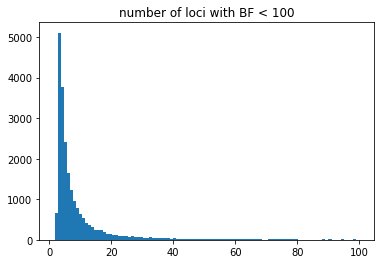



FFP 20418
	number of loci with meanBF >= 0 :  20418 (True)
	number of loci with meanBF >= 10 :  1416
	number of loci with meanBF >= 15 :  810
	number of loci with meanBF >= 20 :  572
	fraction of BF >= 15 :  0.04
	fraction of BF >= 10 :  0.07


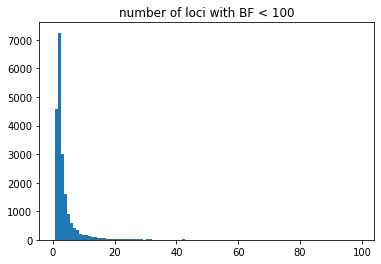



SHM 20501
	number of loci with meanBF >= 0 :  20501 (True)
	number of loci with meanBF >= 10 :  2860
	number of loci with meanBF >= 15 :  2223
	number of loci with meanBF >= 20 :  1912
	fraction of BF >= 15 :  0.11
	fraction of BF >= 10 :  0.14


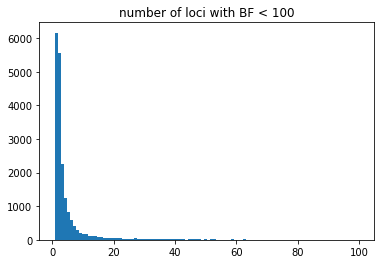



TD 22457
	number of loci with meanBF >= 0 :  22457 (True)
	number of loci with meanBF >= 10 :  10955
	number of loci with meanBF >= 15 :  7159
	number of loci with meanBF >= 20 :  5215
	fraction of BF >= 15 :  0.32
	fraction of BF >= 10 :  0.49
	not all SNPs with BF >= 15 are consistently in top 1% : full (7161) vs 1% (7159) (diff = 2)
	not all SNPs with BF >= 20 are consistently in top 1% : full (5216) vs 1% (5215) (diff = 1)


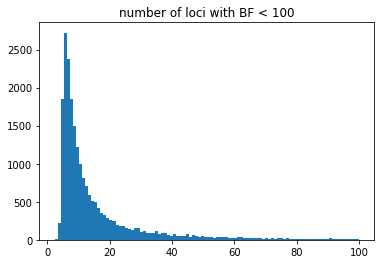



AHM 20596
	number of loci with meanBF >= 0 :  20596 (True)
	number of loci with meanBF >= 10 :  3635
	number of loci with meanBF >= 15 :  2947
	number of loci with meanBF >= 20 :  2582
	fraction of BF >= 15 :  0.14
	fraction of BF >= 10 :  0.18


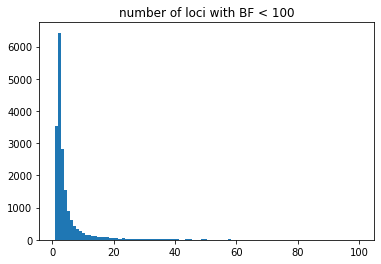



MWMT 21599
	number of loci with meanBF >= 0 :  21599 (True)
	number of loci with meanBF >= 10 :  3630
	number of loci with meanBF >= 15 :  2257
	number of loci with meanBF >= 20 :  1609
	fraction of BF >= 15 :  0.1
	fraction of BF >= 10 :  0.17


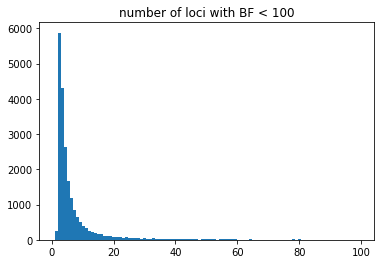



MCMT 23366
	number of loci with meanBF >= 0 :  23366 (True)
	number of loci with meanBF >= 10 :  11548
	number of loci with meanBF >= 15 :  7709
	number of loci with meanBF >= 20 :  5810
	fraction of BF >= 15 :  0.33
	fraction of BF >= 10 :  0.49
	not all SNPs with BF >= 15 are consistently in top 1% : full (7713) vs 1% (7709) (diff = 4)
	not all SNPs with BF >= 20 are consistently in top 1% : full (5811) vs 1% (5810) (diff = 1)


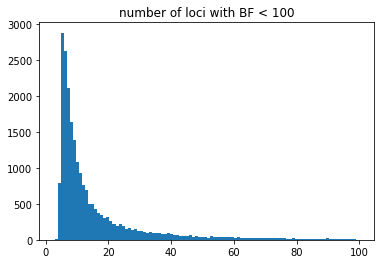



MSP 19420
	number of loci with meanBF >= 0 :  19420 (True)
	number of loci with meanBF >= 10 :  2544
	number of loci with meanBF >= 15 :  1916
	number of loci with meanBF >= 20 :  1602
	fraction of BF >= 15 :  0.1
	fraction of BF >= 10 :  0.13


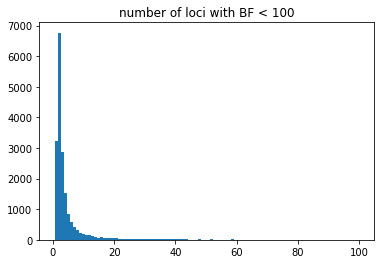



Eref 22348
	number of loci with meanBF >= 0 :  22348 (True)
	number of loci with meanBF >= 10 :  4660
	number of loci with meanBF >= 15 :  2898
	number of loci with meanBF >= 20 :  2064
	fraction of BF >= 15 :  0.13
	fraction of BF >= 10 :  0.21
	not all SNPs with BF >= 15 are consistently in top 1% : full (2899) vs 1% (2898) (diff = 1)


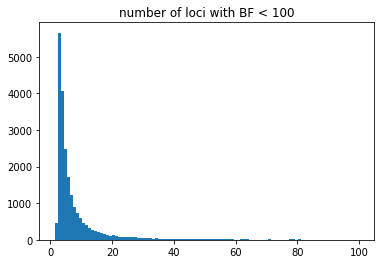



NFFD 21198
	number of loci with meanBF >= 0 :  21198 (True)
	number of loci with meanBF >= 10 :  2170
	number of loci with meanBF >= 15 :  1303
	number of loci with meanBF >= 20 :  909
	fraction of BF >= 15 :  0.06
	fraction of BF >= 10 :  0.1


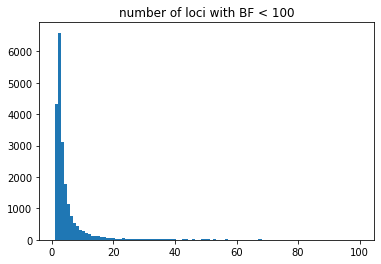



DD5 21528
	number of loci with meanBF >= 0 :  21528 (True)
	number of loci with meanBF >= 10 :  2634
	number of loci with meanBF >= 15 :  1571
	number of loci with meanBF >= 20 :  1098
	fraction of BF >= 15 :  0.07
	fraction of BF >= 10 :  0.12


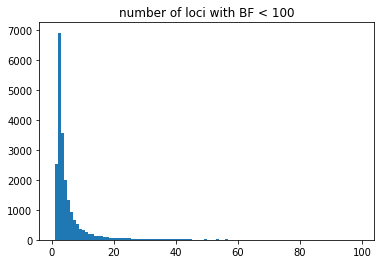



eFFP 20679
	number of loci with meanBF >= 0 :  20679 (True)
	number of loci with meanBF >= 10 :  1880
	number of loci with meanBF >= 15 :  1155
	number of loci with meanBF >= 20 :  794
	fraction of BF >= 15 :  0.06
	fraction of BF >= 10 :  0.09


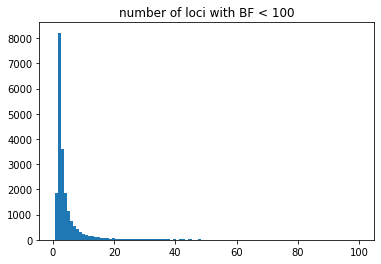



CMD 20045
	number of loci with meanBF >= 0 :  20045 (True)
	number of loci with meanBF >= 10 :  1910
	number of loci with meanBF >= 15 :  1470
	number of loci with meanBF >= 20 :  1236
	fraction of BF >= 15 :  0.07
	fraction of BF >= 10 :  0.1


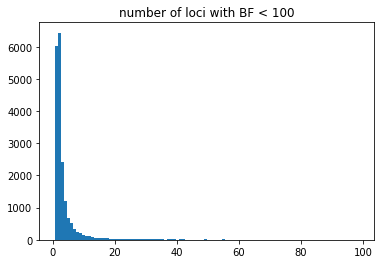



MAP 20374
	number of loci with meanBF >= 0 :  20374 (True)
	number of loci with meanBF >= 10 :  4043
	number of loci with meanBF >= 15 :  3054
	number of loci with meanBF >= 20 :  2618
	fraction of BF >= 15 :  0.15
	fraction of BF >= 10 :  0.2


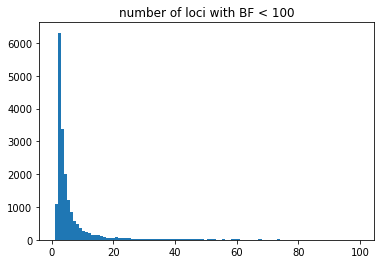



PAS 19970
	number of loci with meanBF >= 0 :  19970 (True)
	number of loci with meanBF >= 10 :  2483
	number of loci with meanBF >= 15 :  1864
	number of loci with meanBF >= 20 :  1552
	fraction of BF >= 15 :  0.09
	fraction of BF >= 10 :  0.12


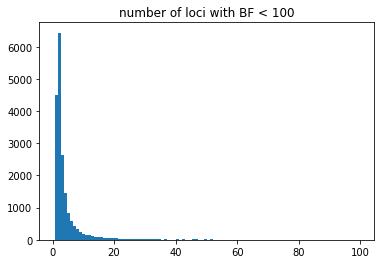



bFFP 20380
	number of loci with meanBF >= 0 :  20380 (True)
	number of loci with meanBF >= 10 :  1322
	number of loci with meanBF >= 15 :  798
	number of loci with meanBF >= 20 :  542
	fraction of BF >= 15 :  0.04
	fraction of BF >= 10 :  0.06


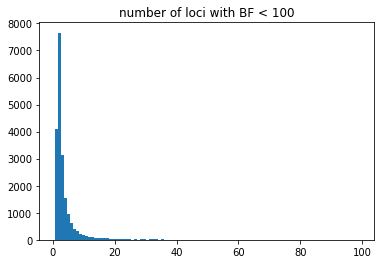



MAT 22167
	number of loci with meanBF >= 0 :  22167 (True)
	number of loci with meanBF >= 10 :  3752
	number of loci with meanBF >= 15 :  2329
	number of loci with meanBF >= 20 :  1697
	fraction of BF >= 15 :  0.11
	fraction of BF >= 10 :  0.17


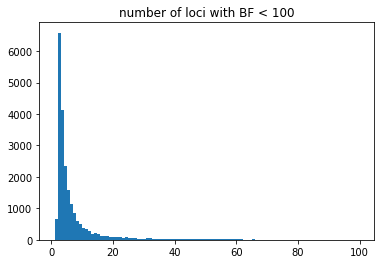



EMT 22684
	number of loci with meanBF >= 0 :  22684 (True)
	number of loci with meanBF >= 10 :  8519
	number of loci with meanBF >= 15 :  5549
	number of loci with meanBF >= 20 :  4111
	fraction of BF >= 15 :  0.24
	fraction of BF >= 10 :  0.38


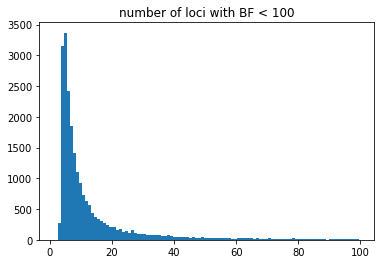



EXT 21977
	number of loci with meanBF >= 0 :  21977 (True)
	number of loci with meanBF >= 10 :  4214
	number of loci with meanBF >= 15 :  2574
	number of loci with meanBF >= 20 :  1783
	fraction of BF >= 15 :  0.12
	fraction of BF >= 10 :  0.19
	not all SNPs with BF >= 15 are consistently in top 1% : full (2575) vs 1% (2574) (diff = 1)


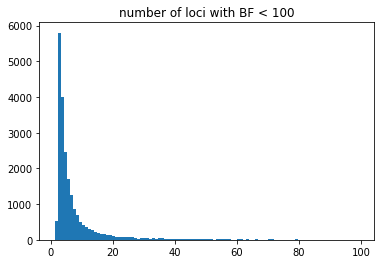




Fraction of meanBF >=15 across envs


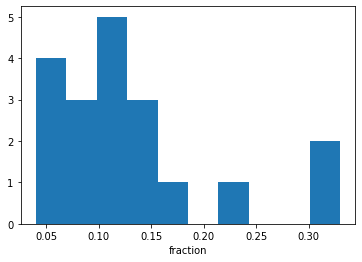

,DD_0,FFP,SHM,TD,AHM,MWMT,MCMT,MSP,Eref,NFFD,DD5,eFFP,CMD,MAP,PAS,bFFP,MAT,EMT,EXT
0,0.16,0.04,0.11,0.32,0.14,0.1,0.33,0.1,0.13,0.06,0.07,0.06,0.07,0.15,0.09,0.04,0.11,0.24,0.12


In [5]:
# for **ONLY** those loci that are consistently ranked in top 1%
# print histograms of bayes factor for each environment
# print fraction of top 1%BFs that have BF ≥ 15 or BF ≥ 20
# also look at histogram for BFs < 100

# also count number of loci across all SNPs that have BF ≥ 15 or BF ≥ 20, print if count doesn't match top 1%

fracs = defaultdict(dict)
for env,df in envdfs.items():
    df = df[df['rank_consistency_top1perc_for-gte3chains'] == True]
    BFs = df['mean_BF']
    small15 = sum(BFs >= 15)
    small20 = sum(BFs >= 20)
    print(ColorText(env).bold(), nrow(df))
    print('\tnumber of loci with meanBF >= 0 : ', sum(BFs >= 0), "(%s)" % str(sum(BFs >= 0) == nrow(df)))
    print('\tnumber of loci with meanBF >= 10 : ', sum(BFs >= 10))
    print('\tnumber of loci with meanBF >= 15 : ', small15)
    print('\tnumber of loci with meanBF >= 20 : ', small20)
    frac = round(sum(BFs >= 15)/nrow(df), 2)
    frac2 = round(sum(BFs >= 10)/nrow(df), 2)
    fracs[env][0] = frac
    print('\tfraction of BF >= 15 : ', frac)
    print('\tfraction of BF >= 10 : ', frac2)
    sum15 = sum(envdfs[env]['mean_BF'] >= 15)
    sum20 = sum(envdfs[env]['mean_BF'] >= 20)
    if small15 != sum15:
        text = '\tnot all SNPs with BF >= 15 are consistently in top 1%'
        print(ColorText(f"{text} : full ({sum15}) vs 1% ({small15}) (diff = {sum15 - small15})").warn().bold())
    if small20 != sum20:
        text = '\tnot all SNPs with BF >= 20 are consistently in top 1%'
        print(ColorText(f"{text} : full ({sum20}) vs 1% ({small20}) (diff = {sum20 - small20})").warn().bold())
    plt.hist(BFs[BFs<100], bins=100)
    plt.title('number of loci with BF < 100')
    plt.show()
    print('\n')
    
# create histogram for fraction of SNPs in consistent top 1% across environments
print(ColorText('\nFraction of meanBF >=15 across envs').bold())
fracdf = pd.DataFrame(fracs)
plt.hist(fracdf.loc[0,:])
plt.xlabel('fraction')
plt.show()
fracdf

In [6]:
df[df['rank_mean_BF']==1]

,chain_1-COVARIABLE,chain_1-MRK,chain_1-M_Pearson,chain_1-SD_Pearson,chain_1-BF(dB),chain_1-Beta_is,chain_1-SD_Beta_is,chain_1-eBPis,chain_1-env,chain_2-COVARIABLE,chain_2-MRK,chain_2-M_Pearson,chain_2-SD_Pearson,chain_2-BF(dB),chain_2-Beta_is,chain_2-SD_Beta_is,chain_2-eBPis,chain_2-env,chain_3-COVARIABLE,chain_3-MRK,chain_3-M_Pearson,chain_3-SD_Pearson,chain_3-BF(dB),chain_3-Beta_is,chain_3-SD_Beta_is,chain_3-eBPis,chain_3-env,chain_4-COVARIABLE,chain_4-MRK,chain_4-M_Pearson,chain_4-SD_Pearson,chain_4-BF(dB),chain_4-Beta_is,chain_4-SD_Beta_is,chain_4-eBPis,chain_4-env,chain_5-COVARIABLE,chain_5-MRK,chain_5-M_Pearson,chain_5-SD_Pearson,chain_5-BF(dB),chain_5-Beta_is,chain_5-SD_Beta_is,chain_5-eBPis,chain_5-env,rank_chain_1-BF,rank_chain_2-BF,rank_chain_3-BF,rank_chain_4-BF,rank_chain_5-BF,mean_BF,rank_mean_BF,BF_gte20_for-gte3chains,BF_gte15_for-gte3chains,rank_consistency_top1perc_for-gte3chains
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
jcf7190000052971-188663,17,147,0.570555,0.05102,63.834731,0.118572,0.017339,11.096378,EXT,17,147,0.566303,0.054728,59.762672,0.119738,0.01555,13.86823,EXT,17,147,0.577755,0.045856,61.559503,0.122156,0.014544,15.35253,EXT,17,147,0.575809,0.05057,63.164111,0.122335,0.016491,12.926019,EXT,17,147,0.583494,0.048323,72.807503,0.123832,0.016119,13.808462,EXT,2,2,2,1,1,2.645881e+06,1,True,True,True
